<a href="https://colab.research.google.com/github/Yaminibazzuri/Projects/blob/main/Diurnal_Profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

PAXHD_PATH = "/content/PAXHD_H.xpt"   # header
PAXHR_PATH = "/content/PAXHR_H.xpt"   # hour-level


In [ ]:
hd = pd.read_sas(PAXHD_PATH, format="xport")
hr = pd.read_sas(PAXHR_PATH, format="xport")

print("Header:", hd.shape)
print("Hour:", hr.shape)
hd.head()


Header: (8913, 9)
Hour: (1477045, 14)


,SEQN,PAXSTS,PAXSENID,PAXFDAY,PAXLDAY,PAXFTIME,PAXETLDY,PAXHAND,PAXORENT
0,73557.0,1.0,b'NEO1G22051089',b'3',b'9',b'16:30:00',b'16:38:59',b'1',b'1'
1,73558.0,1.0,b'NEO1G95371876',b'2',b'9',b'21:30:00',b'21:38:58',b'1',b'1'
2,73559.0,1.0,b'NEO1G50016094',b'7',b'9',b'12:30:00',b'12:38:58',b'1',b'1'
3,73560.0,1.0,b'NEO1G80563207',b'4',b'9',b'17:30:00',b'17:38:56',b'1',b'1'
4,73561.0,1.0,b'NEO1G21632829',b'2',b'9',b'12:30:00',b'12:38:53',b'1',b'1'


In [ ]:
SENTINEL_THRESH = 1e-50

def decode_bytes(x):
    if isinstance(x, (bytes, bytearray)):
        return x.decode("utf-8").strip()
    return x

def clean_xpt(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].map(decode_bytes)
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].mask(df[num_cols].abs() < SENTINEL_THRESH, np.nan)
    return df

hdc = clean_xpt(hd)
hrc = clean_xpt(hr)

# Convert coded/day columns to numeric where applicable
for c in ["PAXFDAY","PAXLDAY","PAXHAND","PAXORENT"]:
    if c in hdc.columns:
        hdc[c] = pd.to_numeric(hdc[c], errors="coerce")

for c in ["PAXDAYH","PAXDAYWH"]:
    if c in hrc.columns:
        hrc[c] = pd.to_numeric(hrc[c], errors="coerce")

hdc.head(), hrc.head()


(      SEQN  PAXSTS       PAXSENID  PAXFDAY  PAXLDAY  PAXFTIME  PAXETLDY  \
 0  73557.0     1.0  NEO1G22051089      3.0      9.0  16:30:00  16:38:59   
 1  73558.0     1.0  NEO1G95371876      2.0      9.0  21:30:00  21:38:58   
 2  73559.0     1.0  NEO1G50016094      7.0      9.0  12:30:00  12:38:58   
 3  73560.0     1.0  NEO1G80563207      4.0      9.0  17:30:00  17:38:56   
 4  73561.0     1.0  NEO1G21632829      2.0      9.0  12:30:00  12:38:53   
 
    PAXHAND  PAXORENT  
 0      1.0       1.0  
 1      1.0       1.0  
 2      1.0       1.0  
 3      1.0       1.0  
 4      1.0       1.0  ,
       SEQN  PAXDAYH  PAXDAYWH   PAXSSNHP  PAXTMH  PAXAISMH  PAXVMH   PAXMTSH  \
 0  73557.0        1         3        NaN    30.0    2960.0    30.0   610.007   
 1  73557.0        1         3   144000.0    60.0   94720.0    60.0   618.132   
 2  73557.0        1         3   432000.0    60.0     640.0    60.0  1062.148   
 3  73557.0        1         3   720000.0    60.0       NaN    60.0   971

In [ ]:
# 80Hz data => 80*60*60 = 288,000 samples per hour
SAMPLES_PER_HOUR = 80 * 60 * 60

# Parse start clock time from header (PAXFTIME = "HH:MM:SS")
def time_to_minutes(t):
    if pd.isna(t):
        return np.nan
    try:
        hh, mm, ss = str(t).split(":")
        return int(hh)*60 + int(mm) + int(ss)/60
    except:
        return np.nan

# Re-initialize hdc to ensure PAXFTIME is present for calculation
hdc = clean_xpt(hd)
# Re-apply numeric conversions from previous cell for 'hdc'
for c in ["PAXFDAY","PAXLDAY","PAXHAND","PAXORENT"]:
    if c in hdc.columns:
        hdc[c] = pd.to_numeric(hdc[c], errors="coerce")

hdc["start_minute"] = hdc["PAXFTIME"].apply(time_to_minutes)
hdc["start_hour"] = np.floor(hdc["start_minute"] / 60).astype("Int64")

# Now truncate hdc after start_minute and start_hour are created
hdc = hdc[["SEQN","start_minute","start_hour"]].dropna(subset=["start_minute"])

# Hour offset since device start (0,1,2,...)
hrc["hour_offset"] = np.floor(hrc["PAXSSNHP"] / SAMPLES_PER_HOUR)

# Join header start time
df = hrc.merge(hdc, on="SEQN", how="left")

# Clock hour of day (0-23)
df["clock_hour"] = (df["start_hour"].astype(float) + (df["hour_offset"] % 24)) % 24

# Keep as nullable integer so NaNs don't crash, and then filter them out
df["clock_hour"] = df["clock_hour"].round().astype("Int64")

# Remove rows where we couldn't compute clock time (missing header start time)
df = df.dropna(subset=["clock_hour"]).copy()
df["clock_hour"] = df["clock_hour"].astype(int)

In [ ]:
# Define valid wake-wear hour: enough wake wear + enough valid minutes
df["valid_wake_hour"] = (df["PAXWWMH"] >= 45) & (df["PAXVMH"] >= 45)

# Hourly intensity proxy
df["intensity_hour"] = df["PAXMTSH"] / df["PAXWWMH"]

wake = df[df["valid_wake_hour"]].copy()

print("Participants:", df["SEQN"].nunique())
print("Participants w/ ≥1 valid wake hour:", wake["SEQN"].nunique())
print("Valid wake-hour rows:", wake.shape[0])

wake[["SEQN","PAXDAYH","clock_hour","PAXWWMH","PAXMTSH","intensity_hour"]].head()


Participants: 7775
Participants w/ ≥1 valid wake hour: 7715
Valid wake-hour rows: 696387


,SEQN,PAXDAYH,clock_hour,PAXWWMH,PAXMTSH,intensity_hour
2,73557.0,1,17,56.0,1062.148,18.966929
3,73557.0,1,18,57.0,971.134,17.037439
4,73557.0,1,19,57.0,1236.984,21.701474
16,73557.0,2,7,58.0,512.481,8.835879
17,73557.0,2,8,60.0,1192.938,19.882300


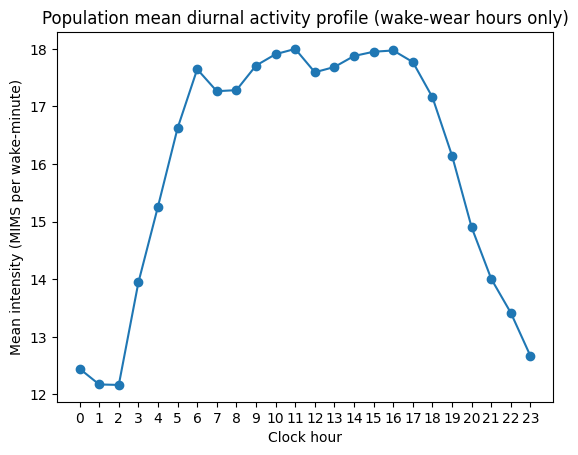

In [ ]:
mean_curve = wake.groupby("clock_hour")["intensity_hour"].mean()

plt.figure()
plt.plot(mean_curve.index, mean_curve.values, marker="o")
plt.xticks(range(0,24))
plt.xlabel("Clock hour")
plt.ylabel("Mean intensity (MIMS per wake-minute)")
plt.title("Population mean diurnal activity profile (wake-wear hours only)")
plt.show()


In [ ]:
# Helper to compute mean intensity in hour ranges
def mean_in_hours(sub, hours):
    tmp = sub[sub["clock_hour"].isin(hours)]
    return tmp["intensity_hour"].mean() if len(tmp) else np.nan

# Define clinically interpretable windows (adjust if you want)
H_MORN_EARLY = list(range(6,9))      # 6-8
H_MORN_LATE  = list(range(10,13))    # 10-12
H_MIDDAY     = list(range(12,15))    # 12-14
H_AFTERNOON  = list(range(15,18))    # 15-17
H_EVENING_EARLY = list(range(18,21)) # 18-20

# Build participant features
g = wake.groupby("SEQN")

feat = pd.DataFrame({
    "n_valid_wake_hours": g.size(),
    "mean_intensity_all": g["intensity_hour"].mean(),
    "sd_intensity_all": g["intensity_hour"].std(),
})

# Windowed means
feat["mean_6_8"]   = g.apply(lambda x: mean_in_hours(x, H_MORN_EARLY))
feat["mean_10_12"] = g.apply(lambda x: mean_in_hours(x, H_MORN_LATE))
feat["mean_12_14"] = g.apply(lambda x: mean_in_hours(x, H_MIDDAY))
feat["mean_15_17"] = g.apply(lambda x: mean_in_hours(x, H_AFTERNOON))
feat["mean_18_20"] = g.apply(lambda x: mean_in_hours(x, H_EVENING_EARLY))

# Meeting-friendly indices
feat["morning_ramp_index"] = feat["mean_10_12"] - feat["mean_6_8"]
feat["evening_dropoff_index"] = feat["mean_12_14"] - feat["mean_18_20"]
feat["diurnal_range"] = g["intensity_hour"].max() - g["intensity_hour"].min()

# Stability metric
feat["cv_intensity_all"] = feat["sd_intensity_all"] / feat["mean_intensity_all"]

# Require enough wake-hour coverage to interpret diurnal shape
feat = feat[feat["n_valid_wake_hours"] >= 40]  # ~ at least 40 wake hours across days
feat = feat.replace([np.inf,-np.inf], np.nan)

print("Participants retained for diurnal phenotyping:", feat.shape[0])
feat.head()


/tmp/ipython-input-4272535278.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat["mean_6_8"]   = g.apply(lambda x: mean_in_hours(x, H_MORN_EARLY))
/tmp/ipython-input-4272535278.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat["mean_10_12"] = g.apply(lambda x: mean_in_hours(x, H_MORN_LATE))
/tmp/ipython-input-4272535278.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the groupin

Participants retained for diurnal phenotyping: 7108


/tmp/ipython-input-4272535278.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feat["mean_18_20"] = g.apply(lambda x: mean_in_hours(x, H_EVENING_EARLY))


,n_valid_wake_hours,mean_intensity_all,sd_intensity_all,mean_6_8,mean_10_12,mean_12_14,mean_15_17,mean_18_20,morning_ramp_index,evening_dropoff_index,diurnal_range,cv_intensity_all
SEQN,,,,,,,,,,,,
73557.0,44,18.018366,3.659320,16.363816,18.023918,20.126203,16.644742,19.433476,1.660102,0.692727,17.172990,0.203088
73558.0,94,12.165781,4.096892,14.503332,12.796412,13.955986,12.749879,12.051879,-1.706920,1.904107,19.285299,0.336755
73559.0,88,11.717172,5.440816,14.615991,12.678182,9.661575,10.173126,7.767654,-1.937810,1.893922,20.002678,0.464345
73560.0,111,27.258729,11.027907,25.160934,26.776985,27.909133,32.435962,22.623272,1.616051,5.285861,59.565021,0.404564
73561.0,78,9.219700,3.055811,10.466860,10.662754,8.852408,9.369063,6.588723,0.195894,2.263685,13.653446,0.331444


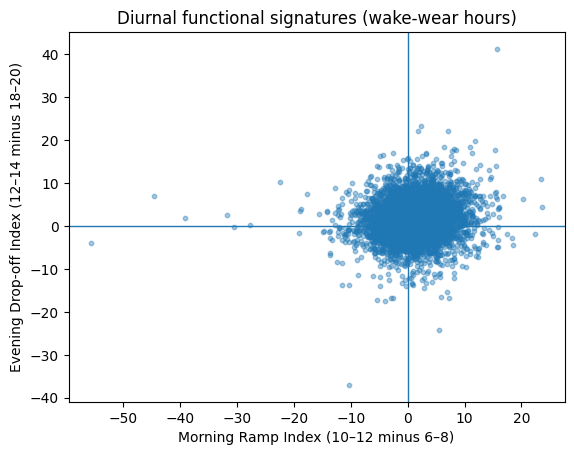

In [ ]:
plt.figure()
plt.scatter(feat["morning_ramp_index"], feat["evening_dropoff_index"], s=10, alpha=0.4)
plt.xlabel("Morning Ramp Index (10–12 minus 6–8)")
plt.ylabel("Evening Drop-off Index (12–14 minus 18–20)")
plt.title("Diurnal functional signatures (wake-wear hours)")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.show()


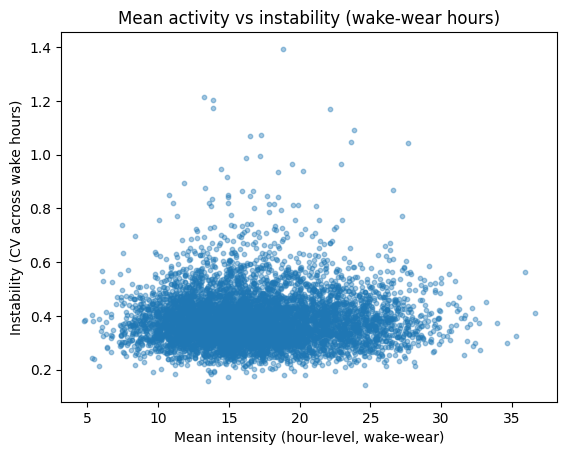

In [ ]:
plt.figure()
plt.scatter(feat["mean_intensity_all"], feat["cv_intensity_all"], s=10, alpha=0.4)
plt.xlabel("Mean intensity (hour-level, wake-wear)")
plt.ylabel("Instability (CV across wake hours)")
plt.title("Mean activity vs instability (wake-wear hours)")
plt.show()


In [ ]:
# Select diurnal features for clustering
cluster_cols = [
    "mean_intensity_all",
    "cv_intensity_all",
    "morning_ramp_index",
    "evening_dropoff_index",
    "diurnal_range",
    "mean_6_8","mean_10_12","mean_12_14","mean_18_20"
]

X = feat[cluster_cols].copy()
X = X.fillna(X.median())

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=10)
feat["phenotype_cluster"] = km.fit_predict(Xs)

feat["phenotype_cluster"].value_counts().sort_index()


,count
phenotype_cluster,
0,530
1,2655
2,1353
3,2570


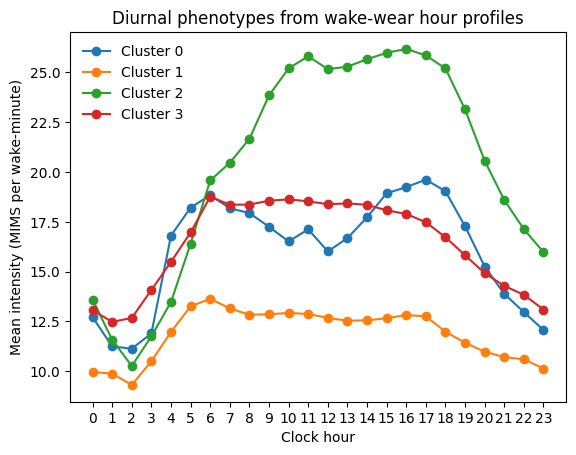

In [ ]:
# Build participant × hour mean intensity matrix
prof = wake.groupby(["SEQN","clock_hour"])["intensity_hour"].mean().reset_index()
prof = prof.merge(feat[["phenotype_cluster"]], left_on="SEQN", right_index=True, how="inner")

# Mean curve per phenotype
curve = prof.groupby(["phenotype_cluster","clock_hour"])["intensity_hour"].mean().reset_index()

plt.figure()
for c in sorted(curve["phenotype_cluster"].unique()):
    sub = curve[curve["phenotype_cluster"]==c]
    plt.plot(sub["clock_hour"], sub["intensity_hour"], marker="o", label=f"Cluster {c}")
plt.xticks(range(0,24))
plt.xlabel("Clock hour")
plt.ylabel("Mean intensity (MIMS per wake-minute)")
plt.title("Diurnal phenotypes from wake-wear hour profiles")
plt.legend(frameon=False)
plt.show()


In [ ]:
summary = feat.groupby("phenotype_cluster")[[
    "n_valid_wake_hours",
    "mean_intensity_all",
    "cv_intensity_all",
    "morning_ramp_index",
    "evening_dropoff_index",
    "diurnal_range"
]].median().round(3)

summary


,n_valid_wake_hours,mean_intensity_all,cv_intensity_all,morning_ramp_index,evening_dropoff_index,diurnal_range
phenotype_cluster,,,,,,
0,101.0,17.184,0.554,-1.245,-0.225,55.479
1,95.0,12.676,0.366,-0.383,1.187,21.764
2,102.0,23.633,0.382,4.636,1.755,45.707
3,104.0,17.386,0.352,0.051,2.293,29.247


In [ ]:
# 1) Participant-level features (KPI tiles / filters)
participant_table = feat.reset_index().rename(columns={"index":"SEQN"})

# 2) Long diurnal profile table (line charts / heatmaps)
diurnal_table = prof.rename(columns={"intensity_hour":"mean_intensity_by_hour"})
diurnal_table = diurnal_table[["SEQN","phenotype_cluster","clock_hour","mean_intensity_by_hour"]]

print("participant_table:", participant_table.shape)
print("diurnal_table:", diurnal_table.shape)

participant_table.head(), diurnal_table.head()


participant_table: (7108, 14)
diurnal_table: (131312, 4)


(      SEQN  n_valid_wake_hours  mean_intensity_all  sd_intensity_all  \
 0  73557.0                  44           18.018366          3.659320   
 1  73558.0                  94           12.165781          4.096892   
 2  73559.0                  88           11.717172          5.440816   
 3  73560.0                 111           27.258729         11.027907   
 4  73561.0                  78            9.219700          3.055811   
 
     mean_6_8  mean_10_12  mean_12_14  mean_15_17  mean_18_20  \
 0  16.363816   18.023918   20.126203   16.644742   19.433476   
 1  14.503332   12.796412   13.955986   12.749879   12.051879   
 2  14.615991   12.678182    9.661575   10.173126    7.767654   
 3  25.160934   26.776985   27.909133   32.435962   22.623272   
 4  10.466860   10.662754    8.852408    9.369063    6.588723   
 
    morning_ramp_index  evening_dropoff_index  diurnal_range  cv_intensity_all  \
 0            1.660102               0.692727      17.172990          0.203088   
 1  